In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

from config import *
from models import *
from masks import *

Using TensorFlow backend.


In [3]:
model = base_model(verbose=False)
model.load_weights(EXAMPLE_MODEL)

In [51]:
img_names = [f for f in os.listdir(TRAIN_IMG_PATH) if f.endswith('.tif')][:10]
len(img_names)

10

In [5]:
img = cv2.imread(TEST_IMG_PATH + img_names[0])[:640, :640, :]

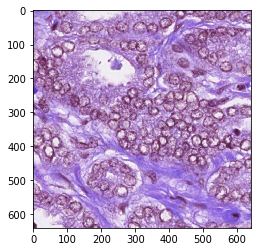

In [6]:
plt.imshow(img)

In [7]:
ground_truth = cv2.imread(TEST_MASK_PATH + img_names[0].rstrip('tif') + 'png', cv2.IMREAD_GRAYSCALE)[:640, :640]

In [8]:
from timeit import default_timer as timer
import pandas as pd
from sklearn import metrics

In [80]:
results_median = pd.DataFrame(columns=['stride', 'time', 'ji', 'dice', 'img'])

k = 0 

for name_idx, name in enumerate(img_names):
    
    img = cv2.imread(TRAIN_IMG_PATH + name)[:320, :320, :]
    ground_truth = cv2.imread(TRAIN_MASK_PATH + name.rstrip('tif') + 'png', cv2.IMREAD_GRAYSCALE)[:320, :320]
    
    for i in range(0, 128, 32):
        stride = 128-i

        start_image = timer()
        result = collect_output_median(model, img, stride=stride)
        end_image = timer()

        mask = otsu_theshold(result)

        ji = metrics.jaccard_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))
        dice = metrics.f1_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))

        results_median.loc[k] = [stride, end_image-start_image, ji, dice, name]
        k += 1

results_median.to_csv(DUMPS_PATH + 'median.csv')

In [53]:
results_median.head(10)

,stride,time,ji,dice,img
0,128,5.983211,0.783104,0.878360,TCGA-G9-6348-01Z-00-DX1.tif
32,128,6.082817,0.765711,0.867312,TCGA-AY-A8YK-01A-01-TS1.tif
64,96,5.719009,0.769173,0.869528,TCGA-AY-A8YK-01A-01-TS1.tif
96,64,6.046678,0.766963,0.868115,TCGA-AY-A8YK-01A-01-TS1.tif
4,128,7.726480,0.717768,0.835699,TCGA-E2-A1B5-01Z-00-DX1.tif
36,128,5.668495,0.801917,0.890071,TCGA-38-6178-01Z-00-DX1.tif
68,96,5.662191,0.805287,0.892143,TCGA-38-6178-01Z-00-DX1.tif
100,64,6.321014,0.815716,0.898506,TCGA-38-6178-01Z-00-DX1.tif
8,128,6.606724,0.717378,0.835434,TCGA-CH-5767-01Z-00-DX1.tif
40,96,6.845959,0.726210,0.841392,TCGA-CH-5767-01Z-00-DX1.tif


In [74]:
results_median.shape

(40, 5)

In [54]:
results = pd.DataFrame(columns=['stride', 'time', 'ji', 'dice', 'img'])

k = 0 

for name in img_names:
    
    img = cv2.imread(TRAIN_IMG_PATH + name)[:320, :320, :]
    ground_truth = cv2.imread(TRAIN_MASK_PATH + name.rstrip('tif') + 'png', cv2.IMREAD_GRAYSCALE)[:320, :320]
    
    for i in range(0, 128, 32):
        stride = 128-i

        start_image = timer()
        result = collect_output_median(model, img, stride=stride, process_predicted_patch=otsu_theshold)
        end_image = timer()

        mask = np.zeros(result.shape, dtype='uint8')
        mask[result>0] = 255

        ji = metrics.jaccard_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))
        dice = metrics.f1_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))

        results.loc[k] = [stride, end_image-start_image, ji, dice, name]
        k += 1

results.to_csv(DUMPS_PATH + 'thresholded_median.csv')

In [55]:
results.head(10)

,stride,time,ji,dice,img
0,128,4.003283,0.787482,0.881107,TCGA-G9-6348-01Z-00-DX1.tif
1,96,3.720222,0.777214,0.874643,TCGA-G9-6348-01Z-00-DX1.tif
2,64,4.146309,0.790238,0.882830,TCGA-G9-6348-01Z-00-DX1.tif
3,32,5.678390,0.784938,0.879513,TCGA-G9-6348-01Z-00-DX1.tif
4,128,3.741433,0.699473,0.823164,TCGA-E2-A1B5-01Z-00-DX1.tif
5,96,3.573997,0.706178,0.827789,TCGA-E2-A1B5-01Z-00-DX1.tif
6,64,3.893832,0.699632,0.823275,TCGA-E2-A1B5-01Z-00-DX1.tif
7,32,5.319177,0.708228,0.829196,TCGA-E2-A1B5-01Z-00-DX1.tif
8,128,3.628316,0.715989,0.834491,TCGA-CH-5767-01Z-00-DX1.tif
9,96,3.540427,0.726988,0.841914,TCGA-CH-5767-01Z-00-DX1.tif


#### COMPARED

In [75]:
print(results_median['dice'].min())
print(results['dice'].min())
print(results_median['dice'].max())
print(results['dice'].max())

0.8128184459079225
0.8096499326502504
0.9208429383043218
0.9205326771368603


Text(0.5, 0.98, 'Dice on 10 train images with different strides')

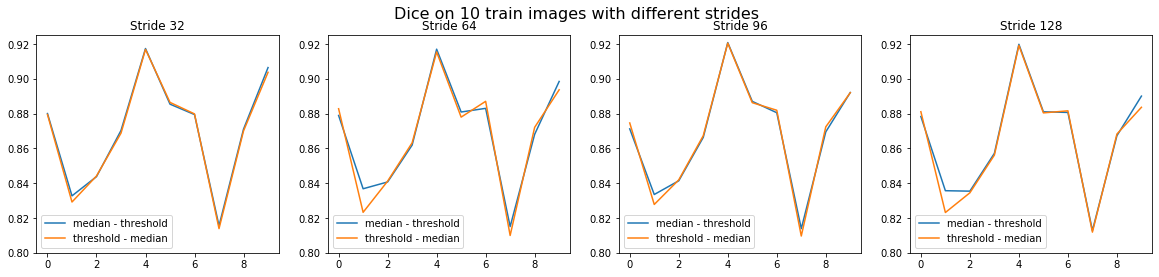

In [76]:
fig = plt.figure(figsize=(20,4))

ax = fig.add_subplot(1, 4, 1)
plt.plot(results_median[results_median['stride']==32]['dice'].tolist(), label = "median - threshold")
plt.plot(results[results['stride']==32]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 32')
ax.set_ylim([0.800, 0.925])

ax = fig.add_subplot(1, 4, 2)
plt.plot(results_median[results_median['stride']==64]['dice'].tolist(), label = "median - threshold")
plt.plot(results[results['stride']==64]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 64')
ax.set_ylim([0.800, 0.925])

ax = fig.add_subplot(1, 4, 3)
plt.plot(results_median[results_median['stride']==96]['dice'].tolist(), label = "median - threshold")
plt.plot(results[results['stride']==96]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 96')
ax.set_ylim([0.800, 0.925])

ax = fig.add_subplot(1, 4, 4)
plt.plot(results_median[results_median['stride']==128]['dice'].tolist(), label = "median - threshold")
plt.plot(results[results['stride']==128]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 128')
ax.set_ylim([0.800, 0.925])

fig.suptitle('Dice on 10 train images with different strides', fontsize=16)

In [63]:
len(results[results['stride']==32]['dice'].tolist())

10

#### COMPARED ON 3 TEST IMAGES

Text(0.5, 0.98, 'Dice on test images with different strides')

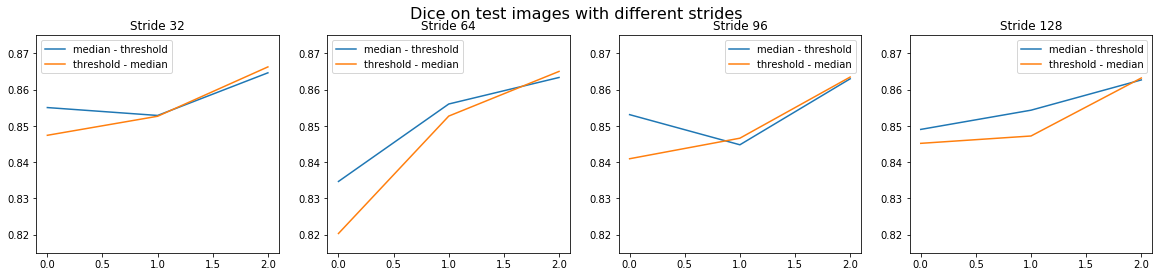

In [49]:
fig = plt.figure(figsize=(20,4))

ax = fig.add_subplot(1, 4, 1)
plt.plot(results_median[results_median['stride']==32]['dice'].to_list(), label = "median - threshold")
plt.plot(results[results['stride']==32]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 32')
ax.set_ylim([0.815, 0.875])

ax = fig.add_subplot(1, 4, 2)
plt.plot(results_median[results_median['stride']==64]['dice'].to_list(), label = "median - threshold")
plt.plot(results[results['stride']==64]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 64')
ax.set_ylim([0.815, 0.875])

ax = fig.add_subplot(1, 4, 3)
plt.plot(results_median[results_median['stride']==96]['dice'].to_list(), label = "median - threshold")
plt.plot(results[results['stride']==96]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 96')
ax.set_ylim([0.815, 0.875])

ax = fig.add_subplot(1, 4, 4)
plt.plot(results_median[results_median['stride']==128]['dice'].to_list(), label = "median - threshold")
plt.plot(results[results['stride']==128]['dice'].tolist(), label = "threshold - median")
plt.legend()
ax.title.set_text('Stride 128')
ax.set_ylim([0.815, 0.875])

fig.suptitle('Dice on test images with different strides', fontsize=16)

In [41]:
results.describe()

,time,ji,dice
count,12.000000,12.000000,12.000000
mean,3.769757,0.740752,0.850937
std,0.885427,0.019549,0.013019
min,2.917208,0.695385,0.820327
25%,3.215256,0.733506,0.846269
50%,3.458045,0.739217,0.850051
75%,4.107076,0.759482,0.863302
max,5.424766,0.764129,0.866296


In [43]:
results_median.describe()

,stride,time,ji,dice
count,12.000000,12.000000,12.000000,12.000000
mean,80.000000,6.427125,0.746031,0.854484
std,37.367949,0.910268,0.013283,0.008767
min,32.000000,5.353727,0.716281,0.834690
25%,56.000000,5.989465,0.742065,0.851935
50%,80.000000,6.134473,0.746288,0.854714
75%,104.000000,6.541529,0.758676,0.862781
max,128.000000,8.270293,0.761593,0.864664


### STRIDE 1-128

#### TIME

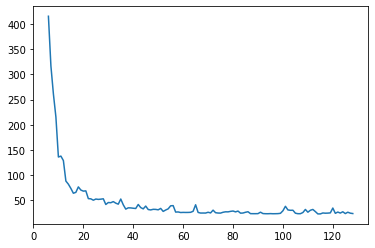

In [20]:
df = pd.read_csv(DUMPS_PATH + 'collected_output_median.csv', index_col=0)
plt.plot(df['stride'], df['time'])

#### results JI for different strides (poor model performance)

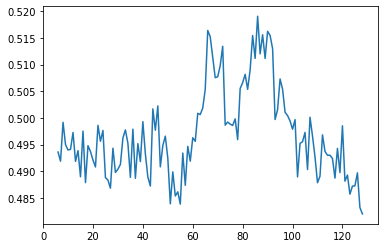

In [13]:
plt.plot(df['stride'], df['ji'])

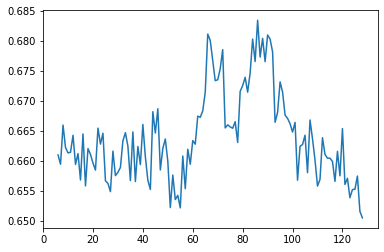

In [15]:
plt.plot(df['stride'], df['dice'])

In [ ]:
# results = pd.DataFrame(columns=['stride', 'time', 'ji', 'dice', 'img'])

# for name in img_names:
    
#     img = cv2.imread(TEST_IMG_PATH + name)[:640, :640, :]
#     ground_truth = cv2.imread(TEST_MASK_PATH + name.rstrip('tif') + 'png', cv2.IMREAD_GRAYSCALE)[:640, :640]
    
#     for i in range(128):
#         stride = 128-i

#         start_image = timer()
#         result = collect_output(model, img, stride=stride)
#         end_image = timer()

#         mask = otsu_theshold(result)

#         ji = metrics.jaccard_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))
#         dice = metrics.f1_score(list(ground_truth.flatten()/255), list(mask.flatten()/255))

#         results.loc[i] = [stride, end_image-start_image, ji, dice, name]

# results.to_csv(DUMPS_PATH + 'collected_output_mean.csv')

In [ ]:
# results.head(10)